In [1]:
# # Do not forget to check if your notebook log collection plugin is working
from mining_extension import check_logging
check_logging("http://3.249.245.244:9999")

Request successful!


In [2]:
import pandas as pd
features_path = 'data/task2/'
test_features = pd.read_pickle(features_path+'test_features.pkl')
train_features = pd.read_pickle(features_path+'train_features.pkl')
validation_features = pd.read_pickle(features_path+'validation_features.pkl')

train_features.index = range(train_features.shape[0])
validation_features.index = range(validation_features.shape[0])
test_features.index = range(test_features.shape[0])

train_features.fillna(0,inplace=True)
test_features.fillna(0,inplace=True)
validation_features.fillna(0,inplace=True)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(5833, 32)
(1927, 32)
(1918, 21)


# Observe the data, conclude on possible ways to extract features

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
train_features.columns

Index(['filename', 'cell_type', 'cell_number', 'execution_count',
       'linesofcomment', 'linesofcode', 'variable_count', 'function_count',
       'text/plain', 'image/png', 'text/html', 'execute_result',
       'display_data', 'stream', 'error', 'text', 'comment',
       'code_line_before', 'code_line_after', 'markdown_heading',
       'packages_info', 'primary_label', 'helper_functions', 'load_data',
       'data_exploration', 'data_preprocessing', 'evaluation', 'modelling',
       'prediction', 'result_visualization', 'save_results', 'comment_only'],
      dtype='object')

In [5]:
set(train_features.filename) & set(validation_features.filename) #hmmm...

set()

In [6]:
train_features['cell_type'].value_counts(), validation_features['cell_type'].value_counts() #🤔

(code    5833
 Name: cell_type, dtype: int64,
 code    1927
 Name: cell_type, dtype: int64)

In [7]:
# The targets are set in stone
y_columns = ['load_data', 'helper_functions', 'data_preprocessing', 'data_exploration', 
             'modelling', 'prediction', 'evaluation',
             'result_visualization', 'save_results', 'comment_only']
y_column = ['primary_label']

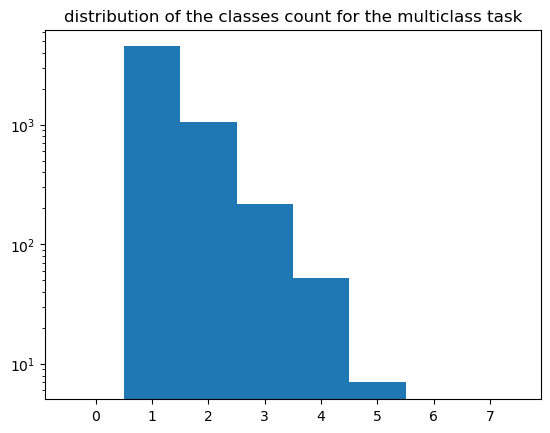

In [8]:
plt.hist(train_features[y_columns].values.sum(1), bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], log=True);
plt.title('distribution of the classes count for the multiclass task');

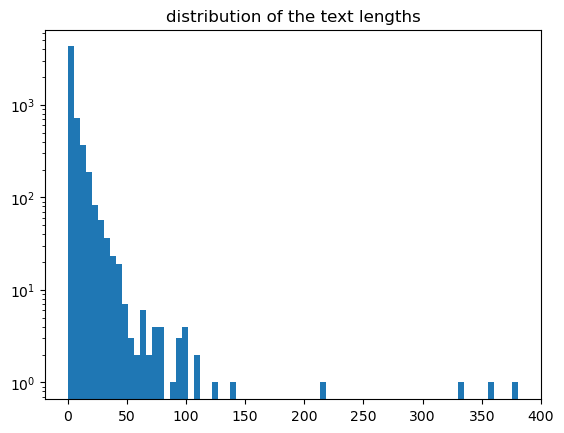

In [9]:
plt.hist(train_features.text.apply(len), log=True, bins=75);
plt.title('distribution of the text lengths');

In [10]:
# Config of the data types defining how to further process it for different trainings
X_columns = set(train_features.columns) - set(y_column) - set(y_columns) - {'filename', 'cell_type'}
X_columns_text = {'packages_info', 'code_line_after', 'code_line_before', 'text', 'comment', 'markdown_heading'}
class_map = {k: i for i, k in enumerate(train_features.primary_label.unique())}

# Train text vectorizers for code and comments

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

In [12]:
from tokenize import generate_tokens
class Readliner:
    def __init__(self, text_lines):
        self.text_lines = text_lines
        self.i = 0
        
    def __call__(self):
        if self.i < len(self):
            ctxt = self.text_lines[self.i]
            self.i += 1
            return ctxt
        return ''
    
    def __len__(self):
        return len(self.text_lines)

def tokenize_py(txt):
    try:
        return [i.string for i in generate_tokens(Readliner(txt))]
    except:
        return ['Fehler']

In [13]:
# code tokenized with builtin python tokenizer
cv = CountVectorizer(tokenizer=tokenize_py, lowercase=False).fit(train_features['text'].values)
tf_transformer = TfidfTransformer().fit(cv.transform(train_features['text'].values))
clf = MultinomialNB().fit(tf_transformer.transform(cv.transform(train_features['text'].values)), 
                          np.vectorize(class_map.get)(train_features[y_column].values).squeeze())

/Users/Yaroslav.Zharov/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
# code tokenized with builtin sklearn tokenizer
cv_ft = CountVectorizer(lowercase=False).fit([' \n '.join(i) for i in train_features['text'].values])
tf_transformer_ft = TfidfTransformer().fit(cv_ft.transform([' \n '.join(i) for i in train_features['text'].values]))
clf_ft = MultinomialNB().fit(tf_transformer_ft.transform(cv_ft.transform([' \n '.join(i) for i in train_features['text'].values])), 
                          np.vectorize(class_map.get)(train_features[y_column].values).squeeze())

In [15]:
# comments tokenized with the builtin sklearn tokenizer
cv_c = CountVectorizer(lowercase=False).fit([' \n '.join(i) for i in train_features['text'].values])
tf_transformer_c = TfidfTransformer().fit(cv_c.transform([' \n '.join(i) for i in train_features['text'].values]))
clf_c = MultinomialNB().fit(tf_transformer_c.transform(cv_c.transform([' \n '.join(i) for i in train_features['text'].values])), 
                          np.vectorize(class_map.get)(train_features[y_column].values).squeeze())

# Take care of the data preparation and the decision model

In [16]:
def prepare_X(df):
    X_numeric = df[X_columns - X_columns_text]
    X_text = df[X_columns_text]
    X_numeric_texts = X_text.applymap(lambda x: len(x) if not isinstance(x, int) else x)
    
    X_nbed_text = clf.predict_proba(tf_transformer.transform(cv.transform(df['text'].values)))
    X_nbed_text_full = clf_ft.predict_proba(tf_transformer_ft.transform(cv_ft.transform([' \n '.join(i) for i in df['text'].values])))
    X_nbed_comment = clf_c.predict_proba(tf_transformer_c.transform(cv_c.transform([' \n '.join(i) for i in df['comment'].values])))
    
    X = pd.merge(X_numeric, X_numeric_texts, left_index=True, right_index=True)
    X = pd.merge(X, pd.DataFrame(X_nbed_text, columns=[f'nb_{i}' for i in range(10)]), 
                 left_index=True, right_index=True)
    X = pd.merge(X, pd.DataFrame(X_nbed_text_full, columns=[f'nb_full_{i}' for i in range(10)]), 
                 left_index=True, right_index=True)
    X = pd.merge(X, pd.DataFrame(X_nbed_comment, columns=[f'nb_full_{i}' for i in range(10)]), 
                 left_index=True, right_index=True)
    return X

def prepare_y(df):
    y_multi = df[y_columns].values
    y_primary = np.vectorize(class_map.get)(df[y_column].values)
    return y_multi, y_primary

In [17]:
X_train = prepare_X(train_features)
y_train_multi, y_train_primary = prepare_y(train_features)
X_val = prepare_X(validation_features)
y_val_multi, y_val_primary = prepare_y(validation_features)

/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3442842625.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_numeric = df[X_columns - X_columns_text]
/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3442842625.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_text = df[X_columns_text]
/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3442842625.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_numeric = df[X_columns - X_columns_text]
/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3442842625.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_text = df[X_columns_text]


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [19]:
rfclf = RandomForestClassifier(min_samples_leaf=10, max_depth=20).fit(X_train, y_train_primary);

/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3261469865.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = RandomForestClassifier(min_samples_leaf=10, max_depth=20).fit(X_train, y_train_primary);


# Validate the model, prepare for tests

In [20]:
f1_score(y_val_primary, rfclf.predict(X_val), average='micro')

0.6953814218993254

In [21]:
f1_score(y_train_primary, rfclf.predict(X_train), average=None)

array([0.94668118, 0.93050648, 0.93729569, 0.90600069, 0.92554901,
       0.86713287, 0.90744921, 0.85714286, 0.80655738, 0.98876404])

In [22]:
f1_score(y_val_primary, rfclf.predict(X_val), average=None)

array([0.92957746, 0.68070175, 0.73221423, 0.65531915, 0.72472784,
       0.3626943 , 0.46808511, 0.44897959, 0.19047619, 0.89361702])

In [23]:
p_test = rfclf.predict(prepare_X(test_features))

/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3442842625.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_numeric = df[X_columns - X_columns_text]
/var/folders/_4/1svrn8px4fd5s0yfgxznnp440000gp/T/ipykernel_20944/3442842625.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_text = df[X_columns_text]


In [24]:
f1_score(y_test_primary, rfclf.predict(X_val), average=None)

NameError: name 'y_test_primary' is not defined